<a href="https://colab.research.google.com/github/jcandane/SSA/blob/main/timeDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True) ## https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html
import scipy.sparse.linalg as spsl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from jax.scipy.signal import convolve2d


def SwissRoll_dataset(n_samples_train:int=1024, n_samples_test:int=1024, noise=0.00, random_state=777):

    from sklearn.datasets import make_swiss_roll

    X_ix, color = make_swiss_roll(n_samples=n_samples_train, noise=noise, random_state=random_state, hole=False)
    np.random.seed(777)
    per   = np.random.permutation(np.arange(len(X_ix)))
    X_ix  = X_ix[per,:]
    color = color[per]

    return X_ix, color

def DMAP_encoder(R_ix, n:int=2, ε:float=6.5, v0=None, m0=1): ## Eager Kernel-Matrix
    """ Computes the diffusion map algorithm for a dataset X
    Parameters
    ----------
    X : numpy.ndarray[2d], dataset shape=(n_samples, n_features)
    n : int, output space
    eps : float, kernel hyperparameter
    v0 : numpy.ndarray[1d], shape=(n_samples,)

    Returns
    -------
    dmap  : numpy.ndarray, shape=(n_samples, n)
    evecs : numpy.ndarray, shape=(n_samples, n)
    evals : numpy.ndarray, shape=(n,)
    """
    if isinstance(ε, float):
        ε_i = ε*jnp.ones(len(X))
    else:
        ε_i = 1.*ε

    matmul = jax.jit(lambda A, B: A @ B) ## for big D

    ## Compute Kernel (pairwise similarity, Sq-Euclidean)
    C  = jnp.sum(R_ix**2, axis=1)
    P  = C[None,:]*jnp.ones(C.shape)[:,None]
    P += C[:,None]*jnp.ones(C.shape)[None,:]
    P -= 2* matmul(R_ix, R_ix.T) #X @ X.T for big D
    D2 = 1.*jnp.abs(P.astype(jnp.float64))
    P  = jnp.exp( - (jnp.abs(P.astype(jnp.float64))) / (ε_i[None,:]*ε_i[:,None]) ) ###

    PP = 1.*P


    R  = ( jnp.sqrt( jnp.sum(P, axis=1)) )**(-1) ## perform kde
    P *= R[None,:] ## RIGHT Normalize
    P *= R[:,None] ## LEFT Normalize

    if v0 is None:
        v0 = np.random.normal(size=(P.shape[0],))
    #evals, evecs = spsl.eigsh(np.asarray(P), k=(n+1), which='LA', v0=v0)
    evals, evecs = jnp.linalg.eigh(P)

    #### we want left-eigenvectors too
    ix    = jnp.argsort(evals)[::-1][m0:]
    evals = jnp.real(evals[ix])[:(n+1)]
    evecs = jnp.real(evecs[:, ix])[:,:(n+1)]
    dmap  = evecs * (jnp.sqrt(1. / evals))[None,:] ## encoding
    return dmap, PP, evals, D2


X, color = SwissRoll_dataset(n_samples_train=512)


import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2], mode='markers', marker=dict(
        size=8,
        color=color,                # set color to an array/list of desired values
        colorscale="rainbow", #'Viridis',   # choose a colorscale
        #opacity=0.99
    ))])
fig.show()

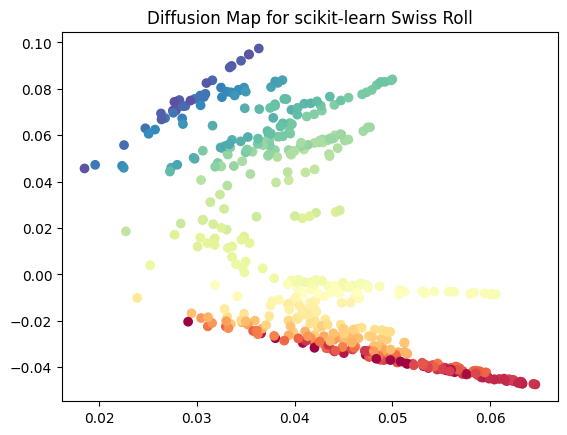

In [2]:
dmap, P, es, D2 = DMAP_encoder(X, n=2, ε=2.5, m0=0)

plt.scatter(dmap[:,0], dmap[:,1], c=color, cmap=plt.cm.Spectral)
plt.title('Diffusion Map for scikit-learn Swiss Roll')
plt.show()

(113, 113)


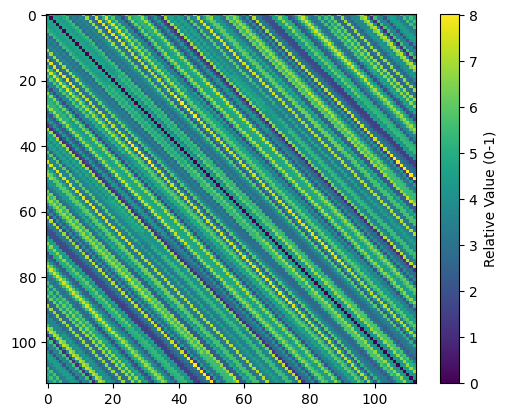

In [3]:
from jax.scipy.signal import convolve2d

K_ij = convolve2d(P, jnp.eye(400), mode='valid')
print( K_ij.shape )

plt.imshow(K_ij*(1 - jnp.eye(K_ij.shape[0])), cmap='viridis', interpolation='none')
plt.colorbar(label='Relative Value (0-1)')
plt.show()

# Try this!

## Now given a time-series $R_{iX}$ (with time index $i,j$ and feature index $X$), then we can compute a distance (or similarity matrix)

## $D^2_{ij} = \texttt{np.linalg.norm}( R_{iX}[:,\texttt{None},:] - R_{jX}[\texttt{None},:,:] , \texttt{axis}=2)$

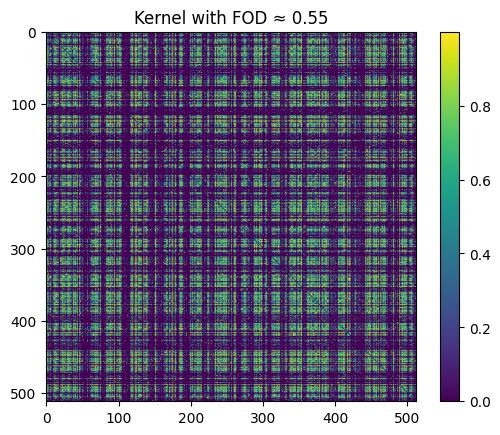

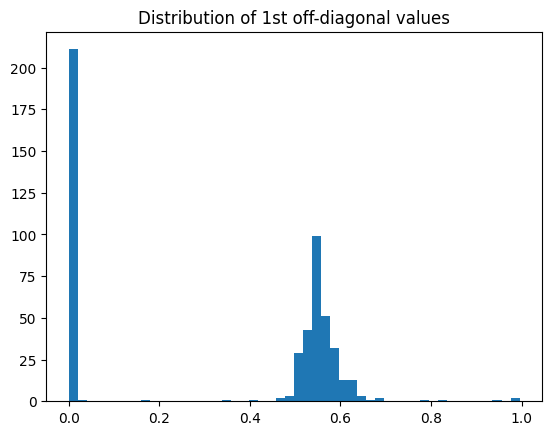

In [4]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# Parameters
n = 20
x = np.linspace(0, 10, n)
#D2 = (x[:, None] - x[None, :]) ** 2
n = D2.shape[0]
target_offdiag = 0.550

def compute_kernel(E, D2):
    outer_E = np.outer(E, E)
    return np.exp(-D2 / outer_E)

# Loss: match first-off-diagonal entries to target
def FOD_loss(log_E, D2, target=0.5):
    E = np.exp(log_E)
    E_i = E[:-1]
    E_ip1 = E[1:]
    D2_fod = np.diag(D2, k=1)  # First-off-diagonal of D^2

    K_fod = np.exp(-D2_fod / (E_i * E_ip1))
    loss = np.sum((K_fod - target) ** 2)
    return loss

# Initial guess
E0     = 2.5*2.5*np.abs( np.random.randn(n) )
log_E0 = np.log( E0 )

# Optimize
result = minimize(FOD_loss, log_E0, args=(D2, target_offdiag), method='L-BFGS-B', options={"maxiter":100})
E_opt = np.exp(result.x)

K_opt = compute_kernel(E_opt, D2)

# Show structure
plt.imshow(K_opt*(1 - jnp.eye(K_opt.shape[0])), cmap='viridis')
plt.title("Kernel with FOD ≈ {:.2f}".format(target_offdiag))
plt.colorbar()
plt.show()

# show 1st off diagonals
plt.hist(np.diag(K_opt, k=1), bins=50)
plt.title("Distribution of 1st off-diagonal values")
plt.show()

# Here!

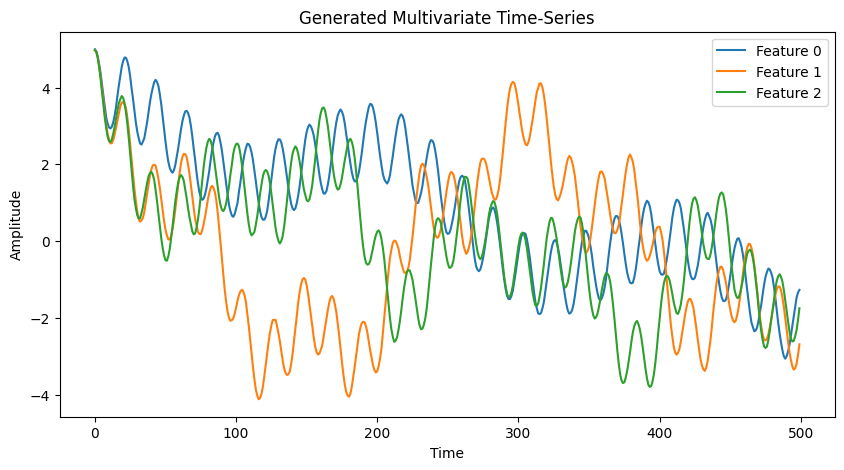

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def sample_power_law_frequencies(size=1,      ## shape of output
                                 N:int=100,   ## number of time points
                                 α:float=2.0  ## power-law parameter
                                 ): ## sampled-frequencies of shape size
    """ Samples real-valued frequencies from a power-law distribution,
    ensuring most frequencies are low but allowing some high values.
    """
    f_max  = N / 2  ## Nyquist limit
    T      = f_max**(1-α)
    u      = np.random.uniform(T, 1, size)  ## Uniform distribution [T,1]
    freqs  = u ** (1/(1 - α))  ## Inverse transform sampling for power-law
    freqs *= np.random.choice([-1, 1], size=size) ## positive & negative freq.
    return freqs

def generate_1_over_f_noise(N, D, S, β=1.0):
    """
    Generates 1/f^β noise using a power-law spectrum for multiple time-series.
    """
    freqs      = np.fft.rfftfreq(N)[1:]  ## Avoid division by zero at f=0
    amplitudes = 1 / (freqs ** (β / 2.0))  ## Power-law spectrum

    # Generate random phases for each (D, S) time-series
    phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs), D, S))

    # Construct Fourier space noise
    noise_spectrum = np.zeros((N//2 + 1, D, S), dtype=complex)
    noise_spectrum[1:] = amplitudes[:, None, None] * phases

    # Convert back to time domain
    noise = np.fft.irfft(noise_spectrum, n=N, axis=0).real  # Shape: (N, D, S)

    return noise / np.std(noise, axis=0, keepdims=True)  # Normalize each (D, S) component

def generate_multivariate_timeseries(N:int,           ### number of time-points
                                     D:int,           ### number of features (time-series)
                                     S:int,           ### number of primative time-series
                                     snr:float=5.0,   ### singal-to-noise ratio
                                     seed:int=7,      ### pseudo-random seed
                                     α:float=1.10     ### power law-freq-distribution
                                     ) -> np.ndarray: ### multivariate timeseries

    np.random.seed(seed)
    F_T   = np.arange(N).reshape(N, 1, 1)  ## shape==(N, 1, 1)
    f_XS  = sample_power_law_frequencies(size=(D, S), N=N, α=α)
    F_TXS = np.exp( 1j * F_T * f_XS[None,:,:] / N) ## shape==(N, D, S)
    noise = generate_1_over_f_noise(N, D, S)  ## shape==(N, D, S)

    # Scale noise to match signal power using SNR
    signal_power = np.linalg.norm(F_TXS, axis=0, keepdims=True)
    noise_power  = np.linalg.norm(noise, axis=0, keepdims=True) + 1e-8 ## Avoid div-by-zero
    noise_scaled = (signal_power / (snr * noise_power)) * noise  ## scale noise
    F_TXS       += noise_scaled

    # Sum over complexity dimension S to get final multivariate time-series
    F_TX = np.sum(F_TXS, axis=2).real  # Shape: (N, D)
    return F_TX


# Generate a toy dataset
N, D, S = 500, 3, 5  # 500 time-points, 3 features, 5 complexity components
F_TX = generate_multivariate_timeseries(N, D, S, snr=100.0, seed=7)

# Plot the generated time-series
plt.figure(figsize=(10, 5))
for x in range(D):
    plt.plot(F_TX[:, x], label=f"Feature {x}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Generated Multivariate Time-Series")
plt.show()

In [13]:
def tridiagonalize(R_tx, target_offdiag=0.125, guess=4.5):

    # Parameters
    D2 = np.linalg.norm( R_tx[:,None,:] - R_tx[None,:,:], axis=2)
    n  = D2.shape[0]

    def compute_kernel(E, D2):
        outer_E = np.outer(E, E)
        return np.exp(-D2 / outer_E)

    # Loss: match first-off-diagonal entries to target
    def FOD_loss(log_E, D2, target=0.5):
        E = np.exp(log_E)
        E_i = E[:-1]
        E_ip1 = E[1:]
        D2_fod = np.diag(D2, k=1)  # First-off-diagonal of D^2

        K_fod = np.exp(-D2_fod / (E_i * E_ip1))
        loss = np.sum((K_fod - target) ** 2)
        return loss

    # Initial guess
    E0     = guess*np.abs( np.random.randn(n) )
    log_E0 = np.log( E0 )

    # Optimize
    result = minimize(FOD_loss, log_E0, args=(D2, target_offdiag), method='L-BFGS-B', options={"maxiter":100})
    E_opt  = np.exp(result.x)
    K_opt  = compute_kernel(E_opt, D2)
    return E_opt, K_opt

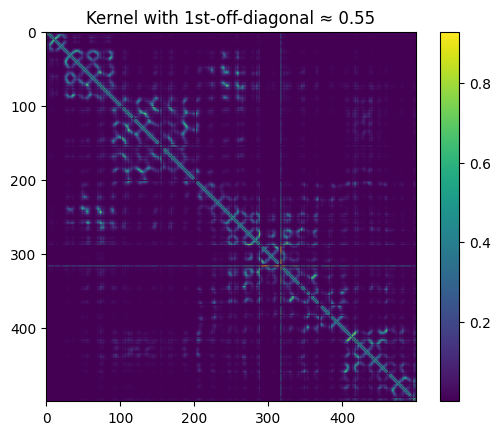

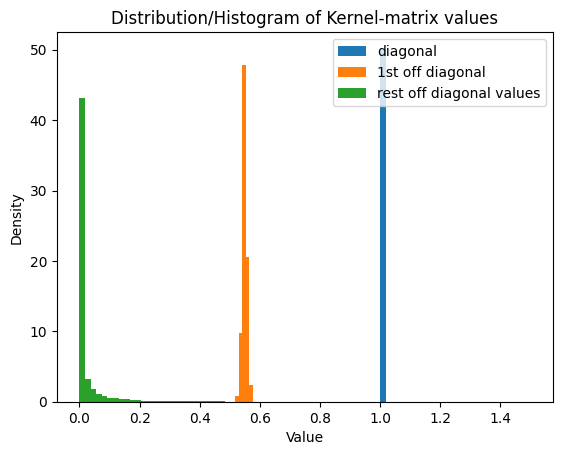

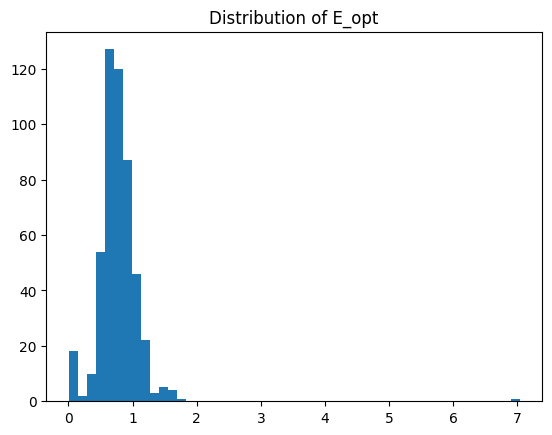

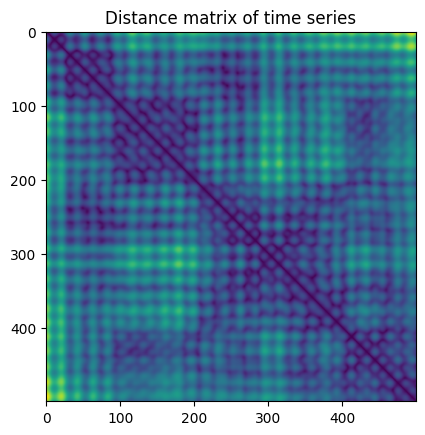

In [20]:
E_opt, K_opt = tridiagonalize(F_TX, target_offdiag=0.55, guess=1.1) ##### <----- time series Here!

main_diag    = jnp.eye(K_opt.shape[0])
upper_diag   = jnp.eye(K_opt.shape[0], k=1 )
lower_diag   = jnp.eye(K_opt.shape[0], k=-1)
tridiag_mask = main_diag + upper_diag + lower_diag

# Show structure
plt.imshow((K_opt*(1 - main_diag) + 0.0000001 ), cmap='viridis')
plt.title("Kernel with 1st-off-diagonal ≈ {:.2f}".format(target_offdiag))
plt.colorbar()
plt.show()

# show 1st off diagonals distribution
plt.hist(np.diag(K_opt, k=0), bins=50, density=True, label="diagonal")
plt.hist(np.diag(K_opt, k=1), bins=50, density=True, label="1st off diagonal")
plt.hist((K_opt*(1- tridiag_mask)).reshape(-1), bins=50, density=True, label="rest off diagonal values")
plt.title("Distribution/Histogram of Kernel-matrix values")
plt.ylabel("Density")
plt.xlabel("Value")
plt.legend()
plt.show()

# show E_opt distribution
plt.hist(E_opt, bins=50)
plt.title("Distribution of E_opt")
plt.show()

DD2 = np.linalg.norm( F_TX[:,None,:] - F_TX[None,:,:], axis=2)
plt.imshow(DD2, cmap='viridis')
plt.title("Distance matrix of time series")
plt.show()